# Prediction of Active Enhancers with FFNN

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from typing import List
from tqdm.auto import tqdm
from multiprocessing import cpu_count
import compress_json
import os
from barplots import barplots

## Models

In [2]:
models = []
kwargs = []

### Decision Trees

In [3]:
from sklearn.tree import DecisionTreeClassifier

def build_decision_tree():
    return DecisionTreeClassifier(
        criterion="gini",
        max_depth=50,
        random_state=42,
        class_weight="balanced"
    )

models.append(build_decision_tree)
kwargs.append({})

### Random forests

In [4]:
from sklearn.ensemble import RandomForestClassifier

def build_random_forest():
    return RandomForestClassifier(
        n_estimators=500,
        criterion="gini",
        max_depth=30,
        random_state=42,
        class_weight="balanced",
        n_jobs=cpu_count()
    )

models.append(build_random_forest)
kwargs.append({})

### Perceptron

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

def build_perceptron():
    perceptron = Sequential([
        Input(shape=(104, )),
        Dense(1, activation="sigmoid")
    ], "Perceptron")

    perceptron.compile(
        optimizer="nadam",
        loss="binary_crossentropy"
    )
    return perceptron
    
models.append(build_perceptron)
kwargs.append(dict(
    epochs=1000,
    batch_size=1024,
    validation_split=0.1,
    shuffle=True,
    verbose=False,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=50)
    ]
))

### Multi-Layer Perceptron (MLP)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_mlp():
    mlp = Sequential([
        Input(shape=(104, )),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid")
    ], "MLP")

    mlp.compile(
        optimizer="nadam",
        loss="binary_crossentropy"
    )
    return mlp

models.append(build_mlp)
kwargs.append(dict(
    epochs=1000,
    batch_size=1024,
    validation_split=0.1,
    shuffle=True,
    verbose=False,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=50)
    ]
))

### Feed-Forward Neural Network (FFNN)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout

def build_ffnn():
    ffnn = Sequential([
        Input(shape=(104, )),
        Dense(256, activation="relu"),
        Dense(128),
        BatchNormalization(),
        Activation("relu"),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ], "FFNN")

    ffnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy"
    )
    return ffnn

models.append(build_ffnn)
kwargs.append(dict(
    epochs=1000,
    batch_size=1024,
    validation_split=0.1,
    shuffle=True,
    verbose=False,
    callbacks=[
        EarlyStopping(monitor="val_loss", mode="min", patience=50)
    ]
))

## Meta-models
Meta-models are models that generate models: this means that, usually, they define hyper-parameters space that are then explored through some (tipically iterative) procedure using some defined score to optimize for choosing the best possible model. Depending on the kind of hyper-parameters exploration to intend to do, you might choose a different method.

Often this kind of optimization are executed on clusters, expecially when tackling the space of structures of neural networks, so for now I will limit to show some of the alternatives without actually running the optimization.

Other important and useful methods are the [Tree of Parzen](https://github.com/hyperopt/hyperopt) and [Bayesian Optimization](https://github.com/fmfn/BayesianOptimization), but I could not manage to fit them within this lesson.

### Grid search
A grid search is just that: you define a grid of hyper-parameters to explore (for instance for two hyper-parameters with 8 available options you get a chess-board of possible combinations) and iteratively you start, one by one (or in parallel) to explore each possible combination.

When the time required by the fit of the model is not a lot and the combination of possible parameters are not that many, one can thing about doing am exhaustive Grid Search.

Tipically, in a cluster scenario, you would run a combination on each available cluster node in parallel.

#### Grid search with Sklearn
Our loyal friend Sklearn, as many other times, has us covered also for a [simple implementation of a Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) (that can also be simply implemented by a product of the hyper-parameters space and a for loop). You can use their implementation as follows:

In [8]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

iris = datasets.load_iris()
parameters = dict(
    max_depth=[2, 10, 20, 50, None],
    class_weight=[None, "balanced"]
)
grid = GridSearchCV(DecisionTreeClassifier(), parameters, scoring="balanced_accuracy")
grid.fit(iris.data, iris.target)

print(grid.best_params_, grid.best_score_)

{'class_weight': None, 'max_depth': 10} 0.9666666666666668


### Random search
A random search is another approach for identifying an optimal set of hyper-parameters. It is a good alternative to grid search when either the time required to fit a model is really high or the hyper-parameters space is very huge.

[Grid search can be outperformed by random search in these settings](http://www.jmlr.org/papers/v13/bergstra12a.html).

As for grid search, also random search is vastly parallelizable and can be run in clusters.

A significant difference between grid search and random search, is that random search can also sample random points from a continuos distribution, whereas grid search will turn the continuos distribution into a discrete one by sampling it uniformely.

#### Random search with Sklearn
As before, [we can use the implementation from Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In [9]:
from sklearn import svm, datasets
from sklearn.model_selection import RandomizedSearchCV

iris = datasets.load_iris()
parameters = dict(
    max_depth=[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, None],
    class_weight=[None, "balanced"]
)
random_search = RandomizedSearchCV(DecisionTreeClassifier(), parameters, scoring="balanced_accuracy", n_iter=10)
random_search.fit(iris.data, iris.target)

print(random_search.best_params_, random_search.best_score_)

{'max_depth': 70, 'class_weight': 'balanced'} 0.9666666666666668


## The experimental setup
After having **well defined** the models we intend to explore, we have to define how we intend to evaluate them, the data used and basically **ALL** the tiny seeming uninportant aspects that we will keep in consideration.

This part is **VERY** important and will help you avoid loosing a lot of time caused by reinveinting the wheel or making beginners' mistakes. 

If it is not already clear, **BEFORE WRITING A SINGLE LINE OF CODE WRITE YOUR EXPERIMENTAL SETUP IN YOUR PROJECT**. Here I showed you the models in code to help you understand them, but in a paper or in the project you should descrive the models you intend to explore in writing.

That said, let's begin: we will evaluate the models we have defined on the enhancers epigenomic dataset, using a 50-fold cross validation. 

## Retrieving the data

In [10]:
from epigenomic_dataset import load_epigenomes
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

# The considered window size
window_size = 200

# Retrieving the input data
X, y = load_epigenomes(
    cell_line = "GM12878",
    dataset = "fantom",
    regions = "enhancers",
    window_size = window_size
)
y = y.values.ravel()

# Imputation of NaN Values
X[X.columns] = KNNImputer(n_neighbors=X.shape[0]//10).fit_transform(X)

# Robust normalization of the values
X[X.columns] = RobustScaler().fit_transform(X)

X = X.values

# Here one should feature selection. How can we do this?

## Preparing the holdouts

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

splits = 51
holdouts = StratifiedShuffleSplit(n_splits=splits, test_size=0.2, random_state=42)

## Training the models

In [12]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score
from sanitize_ml_labels import sanitize_ml_labels

def report(y_true:np.ndarray, y_pred:np.ndarray)->np.ndarray:
    integer_metrics = accuracy_score, balanced_accuracy_score
    float_metrics = roc_auc_score, average_precision_score
    results1 = {
        sanitize_ml_labels(metric.__name__): metric(y_true, np.round(y_pred))
        for metric in integer_metrics
    }
    results2 = {
        sanitize_ml_labels(metric.__name__): metric(y_true, y_pred)
        for metric in float_metrics
    }
    return {
        **results1,
        **results2
    }

In [13]:
def precomputed(results, model:str, holdout:int)->bool:
    df = pd.DataFrame(results)
    if df.empty:
        return False
    return (
        (df.model == model) &
        (df.holdout == holdout)
    ).any()

In [14]:
if os.path.exists("results.json"):
    results = compress_json.local_load("results.json")
else:
    results = []
    
for i, (train, test) in tqdm(enumerate(holdouts.split(X, y)), total=splits, desc="Computing holdouts", dynamic_ncols=True):
    for model_builder, params in tqdm(zip(models, kwargs), total=len(models), desc="Training models", leave=False, dynamic_ncols=True):
        model = model_builder()
        model_name = (
            model.__class__.__name__
            if model.__class__.__name__ != "Sequential"
            else model.name
        )
        if precomputed(results, model_name, i):
            continue
        model.fit(X[train], y[train], **params)
        results.append({
            "model":model_name,
            "run_type":"train",
            "holdout":i,
            **report(y[train], model.predict(X[train]))
        })
        results.append({
            "model":model_name,
            "run_type":"test",
            "holdout":i,
            **report(y[test], model.predict(X[test]))
        })
        compress_json.local_dump(results, "results.json")

## Collecting the results

In [15]:
df = pd.DataFrame(results)
df = df.drop(columns=["holdout"])

df[:5]

,model,run_type,Accuracy,Balanced Accuracy,AUROC,AUPRC
0,DecisionTreeClassifier,train,0.999943,0.999960,0.999960,0.999795
1,DecisionTreeClassifier,test,0.749943,0.689828,0.689828,0.430826
2,RandomForestClassifier,train,1.000000,1.000000,1.000000,1.000000
3,RandomForestClassifier,test,0.826137,0.729755,0.729755,0.542366
4,Perceptron,train,0.829416,0.735404,0.850507,0.755397


In [16]:
barplots(
    df,
    groupby=["model", "run_type"],
    show_legend=False,
    height=5,
    orientation="horizontal"
)

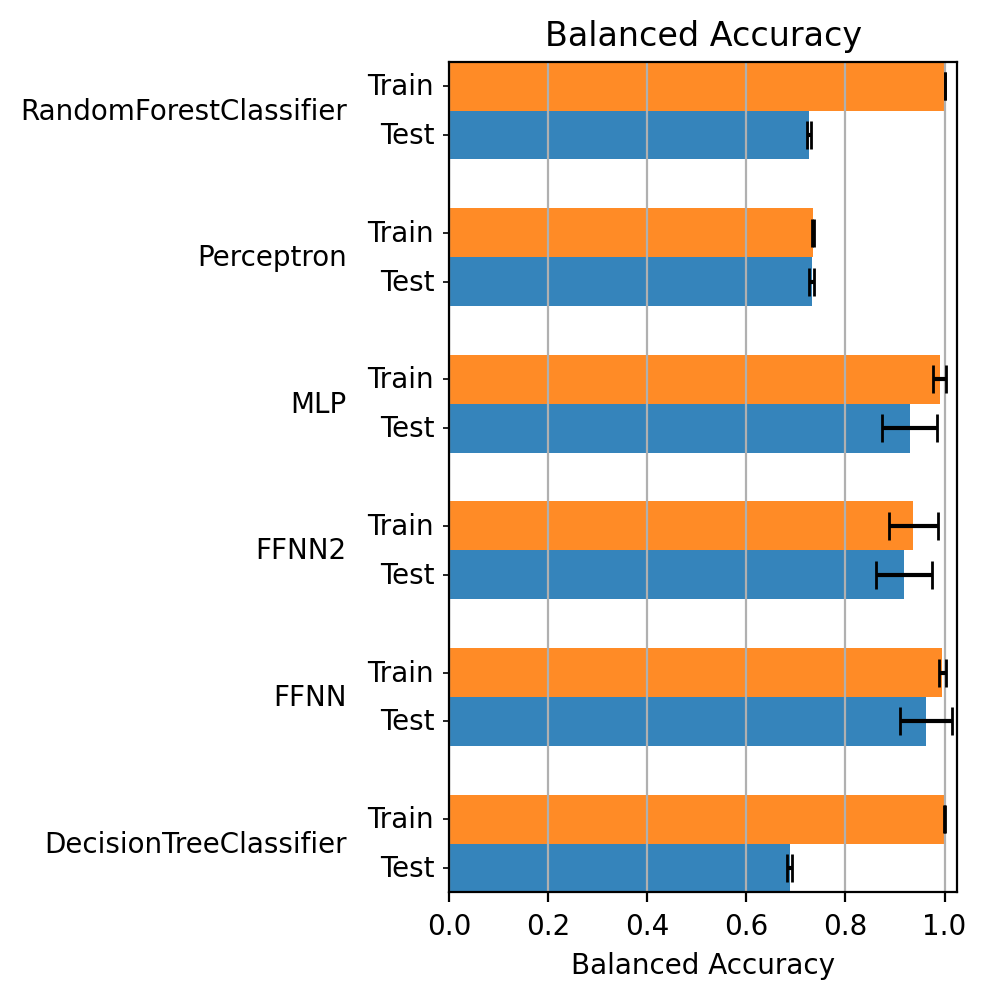

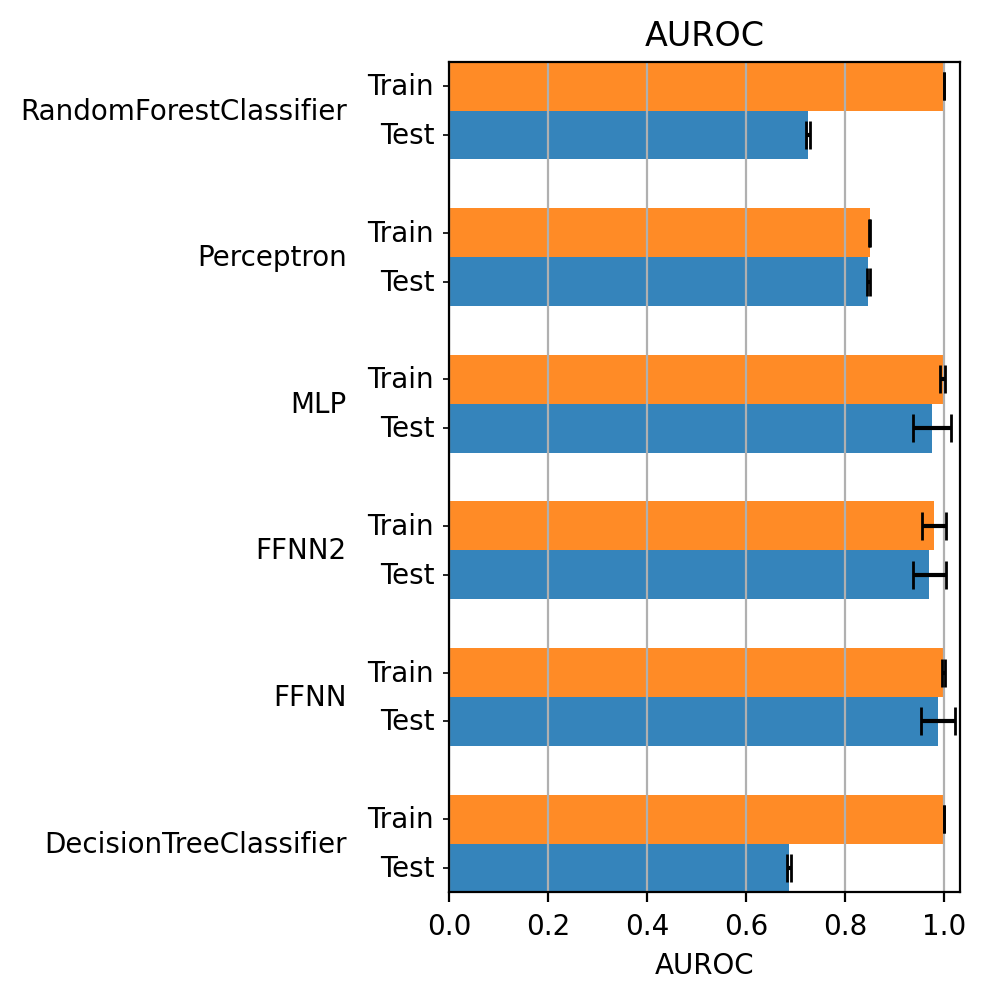

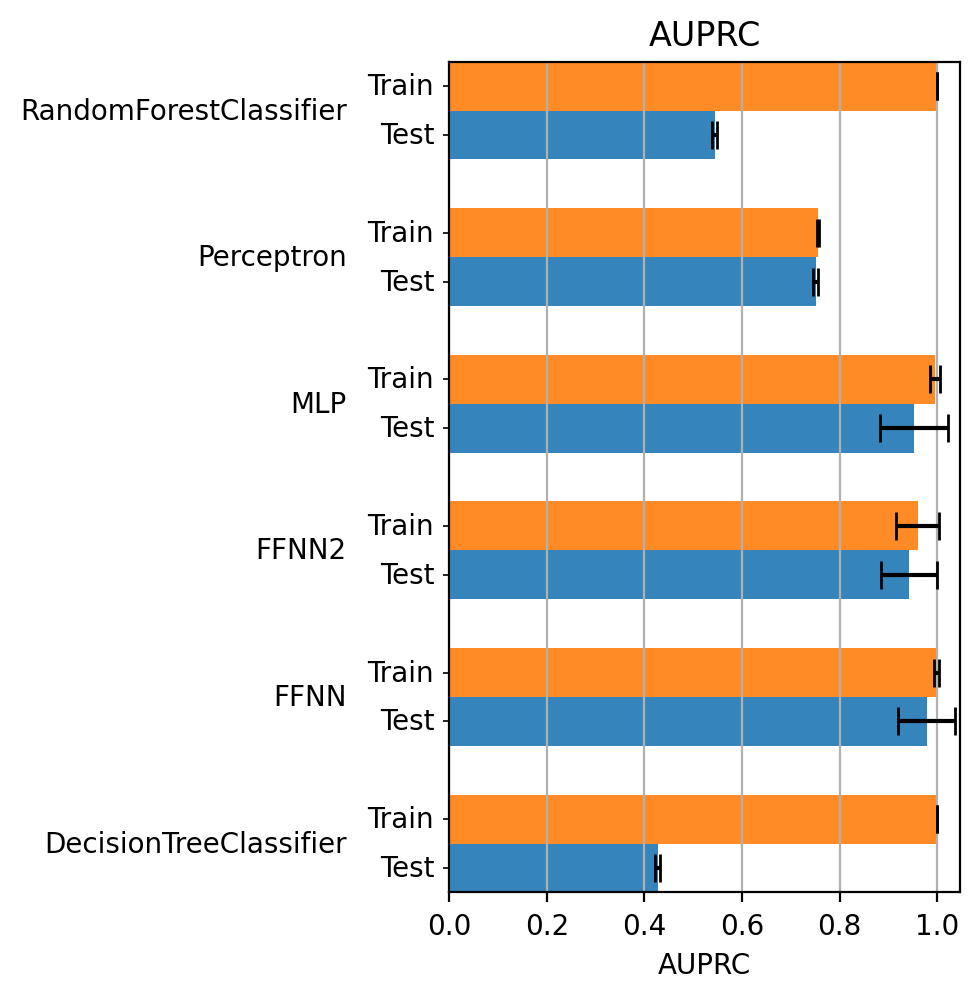

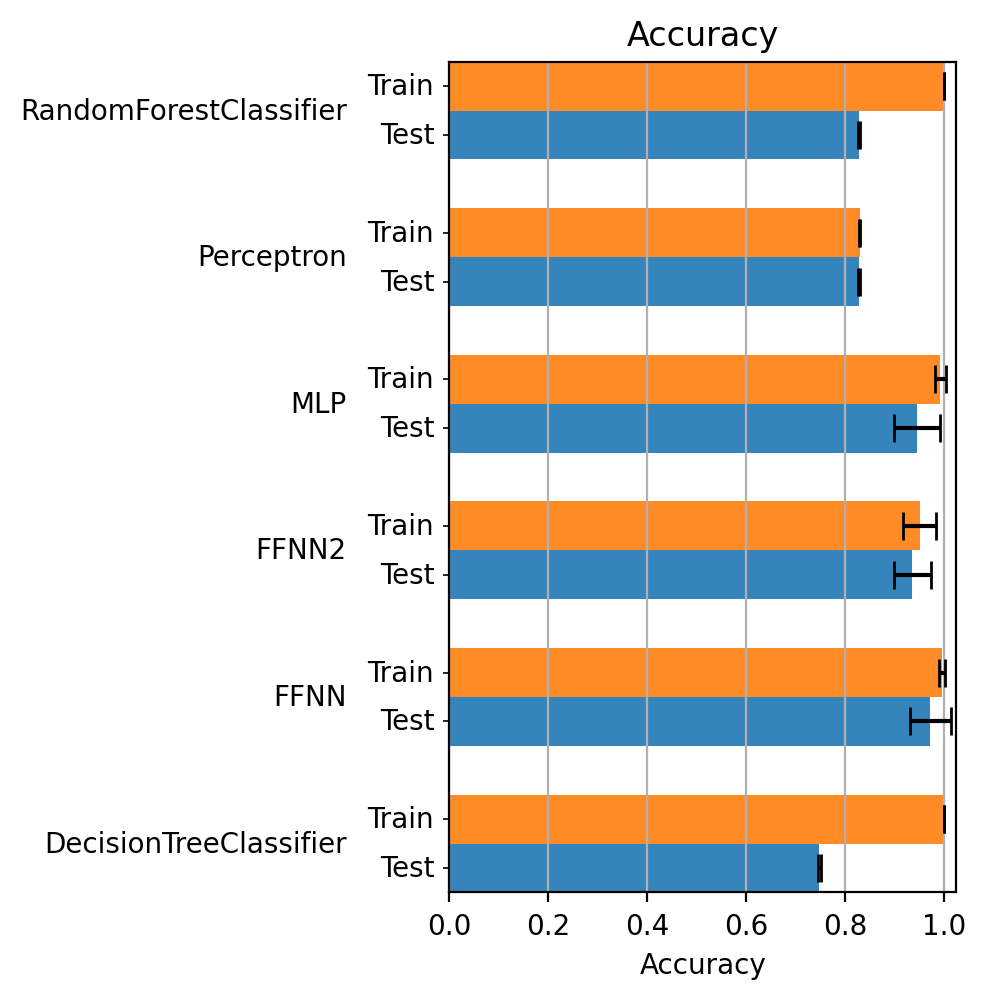

In [17]:
from PIL import Image
from glob import glob

for x in glob("barplots/*.png"):
    display(Image.open(x))

## Statistical tests
To compare the obtained results in a statistically valid manner we need to run a statistical tests. 

Here we will use a Wilcoxon signed-rank test, with the alpha thresholds at $0.01$.

In [18]:
from scipy.stats import wilcoxon

# Here we will be doing a statistical test.
models = df[
    (df.run_type == "test")
]

ffnn_scores = models[models.model=="Perceptron"]
mlp_scores = models[models.model=="DecisionTreeClassifier"]

alpha = 0.01

for metric in ffnn_scores.columns[-4:]:
    print(metric)
    a,  b = ffnn_scores[metric], mlp_scores[metric]
    stats, p_value = wilcoxon(a, b)
    if p_value > alpha:
        print(p_value, "The two models performance are statistically identical.")
    else:
        print(p_value, "The two models performance are different")
        if a.mean() > b.mean():
            print("The first model is better")
        else:
            print("The second model is better")

Accuracy
5.139687871691251e-10 The two models performance are different
The first model is better
Balanced Accuracy
5.145276051717656e-10 The two models performance are different
The first model is better
AUROC
5.145276051717656e-10 The two models performance are different
The first model is better
AUPRC
5.145276051717656e-10 The two models performance are different
The first model is better
